# 01_EU_Export_Time_Series_Forecasting

The goal of the assignment is to build a time series forecasting model with highest possible accuracy to predict the total export from the EU for the period of January-November 2019 (due to the availability of data for verification only for these 11 months at the moment). 

The training data for the period from January 2002 to December 2018 (all the available data), as well as the verification data for the period from January 2019 to November 2019, was extracted from Eurostat's "EU trade since 1988 by CPA 2.1 (DS-1062396)" database (https://ec.europa.eu/eurostat/web/international-trade-in-goods/data/database => https://bit.ly/2RS9JdK)

## 0. Preliminary stage

### 0.1 Activating the working directory:

In [1]:
cd D:\SciKitDatasets\Main

D:\SciKitDatasets\Main


### 0.2 Importing the necessary libraries:

In [2]:
import pandas as pd
import numpy as np

from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR             

from fbprophet import Prophet

import warnings
import itertools
warnings.filterwarnings("ignore")

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 1. Building the models

### 1.1 SARIMAX model with default train data and default parameters

Info on SARIMAX http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

#### 1.1.1 Importing the data and dropping the unnecessary column

In [4]:
df_full = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export.csv')

df_full['Month'] = pd.to_datetime(df_full['Month'], dayfirst=True)

df_train = df_full.drop(['KG'], axis=1)

df_train.head(5)

,Month,EUR
0,2002-01-01,66399826911
1,2002-02-01,68453193661
2,2002-03-01,75565444323
3,2002-04-01,75171579182
4,2002-05-01,77314780951


#### 1.1.2 Transforming the dataset into the format appropriate for SARIMAX

In [5]:
df_train = df_train.set_index("Month")

df_train.head(5)

,EUR
Month,
2002-01-01,66399826911
2002-02-01,68453193661
2002-03-01,75565444323
2002-04-01,75171579182
2002-05-01,77314780951


#### 1.1.3 Preparing train and test data, and checking the test data

In [6]:
train_data = df_train[:len(df_train)-11]
test_data = df_train[len(df_train)-11:]

test_data

,EUR
Month,
2019-01-01,153566052799
2019-02-01,156693063016
2019-03-01,173450979799
2019-04-01,171536186561
2019-05-01,179073500735
2019-06-01,164726052862
2019-07-01,181446454044
2019-08-01,154170589012
2019-09-01,168576407504


#### 1.1.4 Training the SARIMAX model with default parameters

In [7]:
sarimax_model = SARIMAX(train_data['EUR'])
sarimax_result = sarimax_model.fit()
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    EUR   No. Observations:                  204
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5008.527
Date:                Sun, 02 Feb 2020   AIC                          10021.054
Time:                        22:28:38   BIC                          10027.690
Sample:                    01-01-2002   HQIC                         10023.738
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9958      0.005    190.622      0.000       0.986       1.006
sigma2      1.212e+20   3.68e-25    3.3e+44      0.000    1.21e+20    1.21e+20
===================================================================================
Ljung-Box (Q):                      360.46   Jarque-Bera (JB):                 7.00
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               3.74   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

#### 1.1.5 Making the prediction

In [8]:
sarimax_pred = sarimax_result.predict(start = len(train_data), end = len(df_train)-1, 
                                  typ="levels").rename("SARIMAX Predictions")
sarimax_pred

2019-01-01    1.533654e+11
2019-02-01    1.527245e+11
2019-03-01    1.520863e+11
2019-04-01    1.514507e+11
2019-05-01    1.508178e+11
2019-06-01    1.501875e+11
2019-07-01    1.495599e+11
2019-08-01    1.489349e+11
2019-09-01    1.483125e+11
2019-10-01    1.476927e+11
2019-11-01    1.470755e+11
Freq: MS, Name: SARIMAX Predictions, dtype: float64

#### 1.1.6 Checking the accuracy of prediction 

In [9]:
sarimax_pred_df = pd.DataFrame({'Month':sarimax_pred.index, 'EUR_Pred':sarimax_pred.values})

pd.set_option('display.float_format', lambda x: '%.0f' % x)

df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

sarimax_pred_df['EUR_Real'] = df_real['EUR']

sarimax_pred_df = sarimax_pred_df.set_index("Month")

sarimax_pred_df

,EUR_Pred,EUR_Real
Month,,
2019-01-01,153365405997,153566052799
2019-02-01,152724493239,156693063016
2019-03-01,152086258849,173450979799
2019-04-01,151450691636,171536186561
2019-05-01,150817780453,179073500735
2019-06-01,150187514200,164726052862
2019-07-01,149559881825,181446454044
2019-08-01,148934872321,154170589012
2019-09-01,148312474726,168576407504


In [10]:
sum_column = sarimax_pred_df.sum(axis=0)
print (sum_column) 

EUR_Pred   1652207523021
EUR_Real   1866044733813
dtype: float64


In [11]:
accuracy = (sum_column[0]/sum_column[1])*100

accuracy

88.54061711828226

### 1.2 SARIMAX model with default train data and adjusted parameters

#### 1.2.1 Training the SARIMAX model with adjusted parameters

Info on SARIMAX parameters http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

The following parameters provide the best accuracy, close to 100%:

order = (1,1,1), seasonal_order = (1,0,1,12), trend = 'c',enforce_stationarity = False 

In [12]:
sarimax_model = SARIMAX(train_data['EUR'], order = (1,1,1), seasonal_order = (1,0,1,12), trend = 'c',
                      enforce_stationarity = False)
sarimax_result = sarimax_model.fit()
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                EUR   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -4571.560
Date:                            Sun, 02 Feb 2020   AIC                           9155.120
Time:                                    22:28:53   BIC                           9174.570
Sample:                                01-01-2002   HQIC                          9162.999
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.093e+09   4.19e-11   2.61e+19      0.000    1.09e+09    1.09e+09
ar.L1         -0.3171      0.178     -1.785      0.074      -0.665       0.031
ma.L1         -0.2771      0.188     -1.476      0.140      -0.645       0.091
ar.S.L12       0.7566      0.108      6.997      0.000       0.545       0.969
ma.S.L12      -0.0750      0.144     -0.523      0.601      -0.356       0.206
sigma2      9.078e+19   7.84e-22   1.16e+41      0.000    9.08e+19    9.08e+19
===================================================================================
Ljung-Box (Q):                      117.15   Jarque-Bera (JB):                 6.06
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               2.96   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.54e+56. Standard errors may be unstable.
"""

#### 1.2.2 Making the prediction

In [13]:
sarimax_pred = sarimax_result.predict(start = len(train_data), end = len(df_train)-1, 
                                  typ="levels").rename("SARIMAX Predictions")
sarimax_pred

2019-01-01   157648282904
2019-02-01   153340072620
2019-03-01   173243746452
2019-04-01   161188465678
2019-05-01   167436405651
2019-06-01   175516530743
2019-07-01   175011254696
2019-08-01   167739436694
2019-09-01   170373311829
2019-10-01   184209354584
2019-11-01   180701864664
Freq: MS, Name: SARIMAX Predictions, dtype: float64

#### 1.2.3 Checking the accuracy of prediction

In [14]:
sarimax_pred_df = pd.DataFrame({'Month':sarimax_pred.index, 'EUR_Pred':sarimax_pred.values})

pd.set_option('display.float_format', lambda x: '%.0f' % x)

df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

sarimax_pred_df['EUR_Real'] = df_real['EUR']

sarimax_pred_df = sarimax_pred_df.set_index("Month")

sarimax_pred_df

,EUR_Pred,EUR_Real
Month,,
2019-01-01,157648282904,153566052799
2019-02-01,153340072620,156693063016
2019-03-01,173243746452,173450979799
2019-04-01,161188465678,171536186561
2019-05-01,167436405651,179073500735
2019-06-01,175516530743,164726052862
2019-07-01,175011254696,181446454044
2019-08-01,167739436694,154170589012
2019-09-01,170373311829,168576407504


In [15]:
sum_column = sarimax_pred_df.sum(axis=0)
print (sum_column) 

EUR_Pred   1866408726516
EUR_Real   1866044733813
dtype: float64


In [16]:
accuracy = (sum_column[1]/sum_column[0])*100

accuracy

99.98049769603335

### 1.3 VAR model with default train data and default parameters

Info on VAR https://www.statsmodels.org/dev/vector_ar.html

VAR can be used for building time series models with multiple parameters - EUR and KG values of export in this case. 

#### 1.3.1 Importing the data, and transforming it into the format appropriate for VAR

This time the KG column is not removed from the dataframe.

In [17]:
df_full = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export.csv')

df_full['Month'] = pd.to_datetime(df_full['Month'], dayfirst=True)

df_train = df_full.set_index("Month")

df_train.head(5)

,EUR,KG
Month,,
2002-01-01,66399826911,306552133
2002-02-01,68453193661,325511005
2002-03-01,75565444323,335659353
2002-04-01,75171579182,349939261
2002-05-01,77314780951,366585133


#### 1.3.2 Preparing train and test data, and checking the test data

In [18]:
train_data = df_train[:len(df_train)-11]
test_data = df_train[len(df_train)-11:]

test_data

,EUR,KG
Month,,
2019-01-01,153566052799,527185078
2019-02-01,156693063016,539844488
2019-03-01,173450979799,589567195
2019-04-01,171536186561,595362389
2019-05-01,179073500735,593697611
2019-06-01,164726052862,529887601
2019-07-01,181446454044,591654771
2019-08-01,154170589012,545712623
2019-09-01,168576407504,586815714


#### 1.3.3 Training the VAR model with default parameters, and making the prediction

In [19]:
model = VAR(endog=train_data)
model_fit = model.fit()

prediction = model_fit.forecast(model_fit.y, steps=len(test_data))

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})

prediction

array([[152430551787.4, 532491794.1],
       [150788290937.3, 537529468.8],
       [149159524569.3, 538674140.6],
       [147584299669.5, 537749859.9],
       [146082035318.1, 535769765.1],
       [144660806708.4, 533293922.5],
       [143322525012.2, 530629430.4],
       [142065822688.5, 527942304.0],
       [140887656251.7, 525320025.8],
       [139784192449.3, 522806503.9],
       [138751294327.2, 520421601.3]])

#### 1.3.4 Transforming prediction into a dataframe

In [20]:
cols = df_train.columns

pd.set_option('display.float_format', lambda x: '%.0f' % x)
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

pred

,EUR,KG
0,152430551787,532491794
1,150788290937,537529469
2,149159524569,538674141
3,147584299669,537749860
4,146082035318,535769765
5,144660806708,533293923
6,143322525012,530629430
7,142065822688,527942304
8,140887656252,525320026
9,139784192449,522806504


#### 1.3.5 Checking the accuracy of prediction

In [21]:
df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

df_real = df_real.drop(['KG'], axis=1)

df_real['EUR_Pred'] = pred['EUR']

df_real['EUR_Real'] = df_real['EUR']

df_real = df_real.drop(['EUR'], axis=1)

df_real = df_real.set_index("Month")

df_real

,EUR_Pred,EUR_Real
Month,,
01-01-19,152430551787,153566052799
01-02-19,150788290937,156693063016
01-03-19,149159524569,173450979799
01-04-19,147584299669,171536186561
01-05-19,146082035318,179073500735
01-06-19,144660806708,164726052862
01-07-19,143322525012,181446454044
01-08-19,142065822688,154170589012
01-09-19,140887656252,168576407504


In [22]:
sum_column = df_real.sum(axis=0)
print (sum_column) 

EUR_Pred   1595516999719
EUR_Real   1866044733813
dtype: float64


In [23]:
accuracy = (sum_column[0]/sum_column[1])*100

accuracy

85.50261260129083

### 1.4 VAR model with default train data and adjusted parameters

#### 1.4.1 Training the VAR model with adjusted parameters, and making the prediction

Info on VAR parameters https://www.statsmodels.org/dev/vector_ar.html#lag-order-selection

In [24]:
model = VAR(endog=train_data)
model_fit = model.fit(maxlags=4, ic='aic')

prediction = model_fit.forecast(model_fit.y, steps=len(test_data))

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})

prediction

array([[160975119983.0, 549834263.6],
       [166056716191.5, 567488611.6],
       [165542601332.4, 568382932.6],
       [163825692077.6, 567237047.0],
       [165171598034.0, 572862010.6],
       [166476377922.9, 577909227.1],
       [166290089318.3, 578547316.6],
       [166279570725.8, 579460397.0],
       [166824203905.2, 581634648.3],
       [167160387362.0, 583027980.7],
       [167255757288.2, 583655142.1]])

#### 1.4.2 Transforming prediction into a dataframe

In [25]:
cols = df_train.columns

pd.set_option('display.float_format', lambda x: '%.0f' % x)
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

pred

,EUR,KG
0,160975119983,549834264
1,166056716192,567488612
2,165542601332,568382933
3,163825692078,567237047
4,165171598034,572862011
5,166476377923,577909227
6,166290089318,578547317
7,166279570726,579460397
8,166824203905,581634648
9,167160387362,583027981


#### 1.4.3 Checking the accuracy of prediction

In [26]:
df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

df_real = df_real.drop(['KG'], axis=1)

df_real['EUR_Pred'] = pred['EUR']

df_real['EUR_Real'] = df_real['EUR']

df_real = df_real.drop(['EUR'], axis=1)

df_real = df_real.set_index("Month")

df_real

,EUR_Pred,EUR_Real
Month,,
01-01-19,160975119983,153566052799
01-02-19,166056716192,156693063016
01-03-19,165542601332,173450979799
01-04-19,163825692078,171536186561
01-05-19,165171598034,179073500735
01-06-19,166476377923,164726052862
01-07-19,166290089318,181446454044
01-08-19,166279570726,154170589012
01-09-19,166824203905,168576407504


In [27]:
sum_column = df_real.sum(axis=0)
print (sum_column) 

EUR_Pred   1821858114141
EUR_Real   1866044733813
dtype: float64


In [28]:
accuracy = (sum_column[0]/sum_column[1])*100

accuracy

97.63207071773353

### 1.5 VAR model with extended train data and adjusted parameters

#### 1.5.1 Importing the data, and transforming it into the format appropriate for VAR

This time in addition to the export data (in euros - EUR, and kilograms - KG), the data on the import is also present (EUR_import and KG_import)

In [29]:
df_full = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_ext.csv')

df_full['Month'] = pd.to_datetime(df_full['Month'], dayfirst=True)

df_train = df_full.set_index("Month")

df_train.head(5)

,EUR,KG,EUR_Import,KG_Import
Month,,,,
2002-01-01,66399826911,306552133,77944246629,1312535803
2002-02-01,68453193661,325511005,74247984234,1233779301
2002-03-01,75565444323,335659353,77757567288,1238087708
2002-04-01,75171579182,349939261,83725830890,1322987383
2002-05-01,77314780951,366585133,80290435511,1234862387


#### 1.5.2 Preparing train and test data, and checking the test data

In [30]:
train_data = df_train[:len(df_train)-11]
test_data = df_train[len(df_train)-11:]

test_data

,EUR,KG,EUR_Import,KG_Import
Month,,,,
2019-01-01,153566052799,527185078,179553926768,1617279179
2019-02-01,156693063016,539844488,159111600738,1419068135
2019-03-01,173450979799,589567195,170485906736,1461561454
2019-04-01,171536186561,595362389,170305574033,1467346096
2019-05-01,179073500735,593697611,172132982435,1502933087
2019-06-01,164726052862,529887601,159071228979,1389937426
2019-07-01,181446454044,591654771,182290603452,1493635956
2019-08-01,154170589012,545712623,166952828875,1426244834
2019-09-01,168576407504,586815714,173606828344,1380452569


#### 1.5.3 Training the VAR model with adjusted parameters, and making the prediction

In [31]:
model = VAR(endog=train_data)
model_fit = model.fit(maxlags=4, ic='aic')

prediction = model_fit.forecast(model_fit.y, steps=len(test_data))

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})

prediction

array([[146046425883.3, 512403419.4, 163926513950.5, 1505820237.4],
       [149331234480.7, 519536383.6, 158678163020.7, 1404274789.4],
       [162758862461.8, 565347507.8, 167882181585.9, 1503653041.6],
       [153619852269.9, 544377242.2, 161654918662.4, 1457090175.0],
       [152508625857.9, 539368852.4, 159553230966.6, 1436741286.6],
       [156898514693.4, 556479725.8, 163825150159.3, 1461646650.8],
       [155035827433.4, 551215769.8, 161333333173.7, 1437960091.8],
       [155999456298.7, 554539805.7, 161563393914.9, 1443869787.7],
       [155688309844.8, 555076671.8, 161756607625.2, 1440521531.9],
       [155536740584.8, 554374869.6, 160993544920.3, 1431809917.3],
       [156437434025.5, 557668906.1, 161578774119.2, 1435911560.7]])

#### 1.5.4 Transforming prediction into a dataframe

In [32]:
cols = df_train.columns

pd.set_option('display.float_format', lambda x: '%.0f' % x)
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,4):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

pred

,EUR,KG,EUR_Import,KG_Import
0,146046425883,512403419,163926513950,1505820237
1,149331234481,519536384,158678163021,1404274789
2,162758862462,565347508,167882181586,1503653042
3,153619852270,544377242,161654918662,1457090175
4,152508625858,539368852,159553230967,1436741287
5,156898514693,556479726,163825150159,1461646651
6,155035827433,551215770,161333333174,1437960092
7,155999456299,554539806,161563393915,1443869788
8,155688309845,555076672,161756607625,1440521532
9,155536740585,554374870,160993544920,1431809917


#### 1.5.5 Checking the accuracy of prediction

In [33]:
df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

df_real = df_real.drop(['KG'], axis=1)

df_real['EUR_Pred'] = pred['EUR']

df_real['EUR_Real'] = df_real['EUR']

df_real = df_real.drop(['EUR'], axis=1)

df_real = df_real.set_index("Month")

df_real

,EUR_Pred,EUR_Real
Month,,
01-01-19,146046425883,153566052799
01-02-19,149331234481,156693063016
01-03-19,162758862462,173450979799
01-04-19,153619852270,171536186561
01-05-19,152508625858,179073500735
01-06-19,156898514693,164726052862
01-07-19,155035827433,181446454044
01-08-19,155999456299,154170589012
01-09-19,155688309845,168576407504


In [34]:
sum_column = df_real.sum(axis=0)
print (sum_column) 

EUR_Pred   1699861283834
EUR_Real   1866044733813
dtype: float64


In [35]:
accuracy = (sum_column[0]/sum_column[1])*100

accuracy

91.09434800958498

#### 1.5.6 Comments the extended data usage

The attempts to combine four variables in section 1.5, same as the combination of two variables in sections 1.3-1.4, haven't led to the production of the most accurate model in this case. The two visualizations below clearly show that there are some serious differences in the dynamics of the utilized variables, and this adds unnecessary confusion during the training of models, thus decreasing their accuracy.

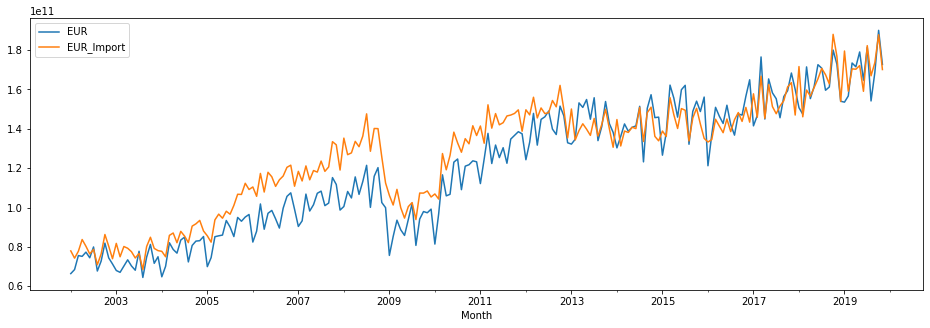

In [36]:
df_train['EUR'].plot(figsize = (16,5), legend=True)
df_train['EUR_Import'].plot(figsize = (16,5), legend=True);

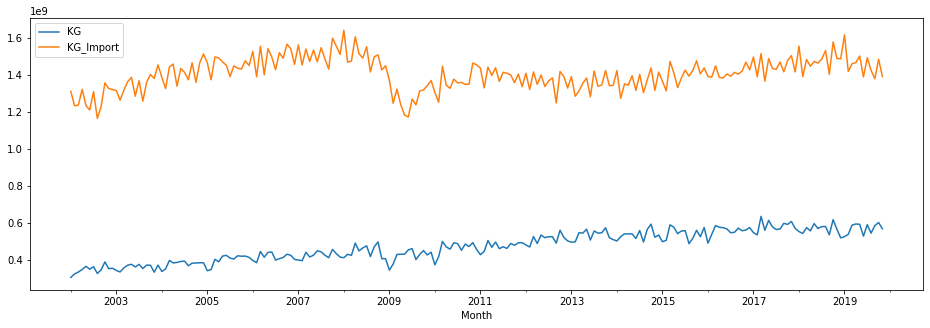

In [37]:
df_train['KG'].plot(figsize = (16,5), legend=True)
df_train['KG_Import'].plot(figsize = (16,5), legend=True);

### 1.6 SARIMAX model with post-crisis train data and adjusted parameters

It might be worth trying to only use the data from the period after the 2008 financial crisis, as removing the sharp decrease in export value between 2008 and 2009 can help to improve the accuracy of the prediction. 

#### 1.6.1 Justification for using post-crisis data 

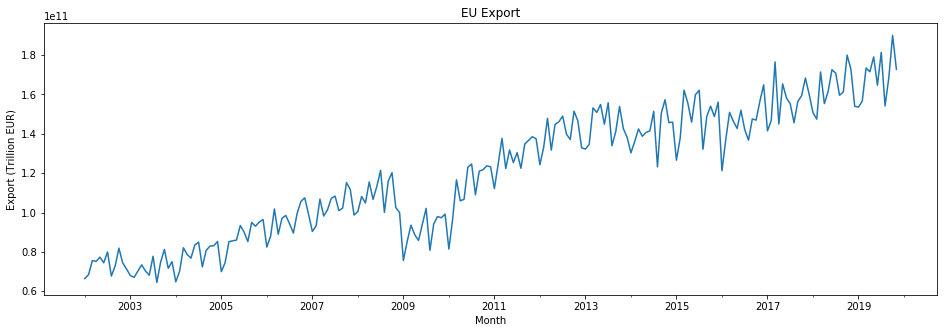

In [38]:
ax = df_train['EUR'].plot(figsize = (16,5), title = "EU Export")
ax.set(xlabel='Month', ylabel='Export (Trillion EUR)');

#### 1.6.2 Importing the data and dropping the unnecessary column

In [39]:
df_full = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_crisis.csv')

df_full['Month'] = pd.to_datetime(df_full['Month'], dayfirst=True)

df_train = df_full.drop(['KG'], axis=1)

df_train.head(5)

,Month,EUR
0,2009-01-01,75648828964
1,2009-02-01,85241108352
2,2009-03-01,93561254498
3,2009-04-01,88663956646
4,2009-05-01,85811123238


#### 1.6.3 Transforming the dataset into the format appropriate for SARIMAX

In [40]:
df_train = df_train.set_index("Month")

df_train.head(5)

,EUR
Month,
2009-01-01,75648828964
2009-02-01,85241108352
2009-03-01,93561254498
2009-04-01,88663956646
2009-05-01,85811123238


#### 1.6.4 Preparing train and test data, and checking the test data

In [41]:
train_data = df_train[:len(df_train)-11]
test_data = df_train[len(df_train)-11:]

test_data

,EUR
Month,
2019-01-01,153566052799
2019-02-01,156693063016
2019-03-01,173450979799
2019-04-01,171536186561
2019-05-01,179073500735
2019-06-01,164726052862
2019-07-01,181446454044
2019-08-01,154170589012
2019-09-01,168576407504


#### 1.6.5 Training the SARIMAX model with adjusted parameters

In [42]:
sarimax_model = SARIMAX(train_data['EUR'], order = (1,1,1), seasonal_order = (1,0,1,12), trend = 'c',
                      enforce_stationarity = False)
sarimax_result = sarimax_model.fit()
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                EUR   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2549.754
Date:                            Sun, 02 Feb 2020   AIC                           5111.509
Time:                                    22:30:10   BIC                           5127.432
Sample:                                01-01-2009   HQIC                          5117.961
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.757e+09   4.58e-11   3.84e+19      0.000    1.76e+09    1.76e+09
ar.L1         -0.3615      0.260     -1.392      0.164      -0.870       0.148
ma.L1         -0.2523      0.306     -0.825      0.409      -0.851       0.347
ar.S.L12       0.6882      0.162      4.249      0.000       0.371       1.006
ma.S.L12       0.0330      0.205      0.161      0.872      -0.369       0.435
sigma2      1.098e+20   1.09e-21      1e+41      0.000     1.1e+20     1.1e+20
===================================================================================
Ljung-Box (Q):                       69.31   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               1.80   Skew:                            -0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.77e+56. Standard errors may be unstable.
"""

#### 1.6.6 Making the prediction

In [43]:
sarimax_pred = sarimax_result.predict(start = len(train_data), end = len(df_train)-1, 
                                  typ="levels").rename("SARIMAX Predictions")
sarimax_pred

2019-01-01   159356443329
2019-02-01   154413741030
2019-03-01   173636022298
2019-04-01   163521548780
2019-05-01   168922742679
2019-06-01   178261237793
2019-07-01   178301537443
2019-08-01   171683592934
2019-09-01   173891149925
2019-10-01   188598915532
2019-11-01   184458148905
Freq: MS, Name: SARIMAX Predictions, dtype: float64

#### 1.6.7 Checking the accuracy of prediction

In [44]:
sarimax_pred_df = pd.DataFrame({'Month':sarimax_pred.index, 'EUR_Pred':sarimax_pred.values})

pd.set_option('display.float_format', lambda x: '%.0f' % x)

df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

sarimax_pred_df['EUR_Real'] = df_real['EUR']

sarimax_pred_df = sarimax_pred_df.set_index("Month")

sarimax_pred_df

,EUR_Pred,EUR_Real
Month,,
2019-01-01,159356443329,153566052799
2019-02-01,154413741030,156693063016
2019-03-01,173636022298,173450979799
2019-04-01,163521548780,171536186561
2019-05-01,168922742679,179073500735
2019-06-01,178261237793,164726052862
2019-07-01,178301537443,181446454044
2019-08-01,171683592934,154170589012
2019-09-01,173891149925,168576407504


In [45]:
sum_column = sarimax_pred_df.sum(axis=0)
print (sum_column) 

EUR_Pred   1895045080648
EUR_Real   1866044733813
dtype: float64


In [46]:
accuracy = (sum_column[1]/sum_column[0])*100

accuracy

98.46967509475763

### 1.7 Prophet model with default train data

Info on the Prophet model https://facebook.github.io/prophet/docs/quick_start.html

#### 1.7.1 Importing the data, and transforming it into the format appropriate for Prophet

In [47]:
df_full = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export.csv')

df_full['Month'] = pd.to_datetime(df_full['Month'], dayfirst=True)

df_full['ds'] = df_full['Month']
df_full['y'] = df_full['EUR']

df_train = df_full.drop(['Month', 'EUR', 'KG'], axis=1)

df_train.head(5)

,ds,y
0,2002-01-01,66399826911
1,2002-02-01,68453193661
2,2002-03-01,75565444323
3,2002-04-01,75171579182
4,2002-05-01,77314780951


#### 1.7.2 Preparing train and test data, and checking the test data

In [48]:
train_data = df_train[:len(df_train)-11]
test_data = df_train[len(df_train)-11:]

del test_data['y']

test_data

,ds
204,2019-01-01
205,2019-02-01
206,2019-03-01
207,2019-04-01
208,2019-05-01
209,2019-06-01
210,2019-07-01
211,2019-08-01
212,2019-09-01
213,2019-10-01


#### 1.7.3 Training the Prophet model

In [49]:
model = Prophet(yearly_seasonality=True)
model.fit(train_data)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 1.7.4 Making the prediction, and checking the accuracy

In [50]:
forecast = model.predict(test_data)

df_1 = forecast[['yhat']]

df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

df_real = df_real.drop(['KG'], axis=1)

df_real['EUR_Pred'] = df_1['yhat']

df_real['EUR_Real'] = df_real['EUR']

df_real = df_real.drop(['EUR'], axis=1)

df_real = df_real.set_index("Month")

df_real

,EUR_Pred,EUR_Real
Month,,
01-01-19,150789101029,153566052799
01-02-19,157670306208,156693063016
01-03-19,170527606332,173450979799
01-04-19,162847994026,171536186561
01-05-19,165382634671,179073500735
01-06-19,168625334787,164726052862
01-07-19,172036099836,181446454044
01-08-19,157188206100,154170589012
01-09-19,167485748753,168576407504


In [51]:
sum_column = df_real.sum(axis=0)
print (sum_column) 

EUR_Pred   1816462631902
EUR_Real   1866044733813
dtype: float64


In [52]:
accuracy = (sum_column[0]/sum_column[1])*100

accuracy

97.34293069119668

### 1.8 Prophet model with post-crisis train data

#### 1.8.1 Importing the data, and transforming it into the format appropriate for Prophet

In [53]:
df_full = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_crisis.csv')

df_full['Month'] = pd.to_datetime(df_full['Month'], dayfirst=True)

df_full['ds'] = df_full['Month']
df_full['y'] = df_full['EUR']

df_train = df_full.drop(['Month', 'EUR', 'KG'], axis=1)

df_train.head(5)

,ds,y
0,2009-01-01,75648828964
1,2009-02-01,85241108352
2,2009-03-01,93561254498
3,2009-04-01,88663956646
4,2009-05-01,85811123238


#### 1.8.2 Preparing train and test data, and checking the test data

In [54]:
train_data = df_train[:len(df_train)-11]
test_data = df_train[len(df_train)-11:]

del test_data['y']

test_data

,ds
120,2019-01-01
121,2019-02-01
122,2019-03-01
123,2019-04-01
124,2019-05-01
125,2019-06-01
126,2019-07-01
127,2019-08-01
128,2019-09-01
129,2019-10-01


#### 1.8.3 Training the Prophet model

In [55]:
model = Prophet(yearly_seasonality=True)
model.fit(train_data)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 1.8.4 Making the prediction, and checking the accuracy

In [56]:
forecast = model.predict(test_data)

df_1 = forecast[['yhat']]

df_real = pd.read_csv('D:\\SciKitDatasets\\Main\\eu_export_check.csv')

df_real = df_real.drop(['KG'], axis=1)

df_real['EUR_Pred'] = df_1['yhat']

df_real['EUR_Real'] = df_real['EUR']

df_real = df_real.drop(['EUR'], axis=1)

df_real = df_real.set_index("Month")

df_real

,EUR_Pred,EUR_Real
Month,,
01-01-19,149257507522,153566052799
01-02-19,159080978737,156693063016
01-03-19,178052352954,173450979799
01-04-19,166309759761,171536186561
01-05-19,166490042747,179073500735
01-06-19,171527597759,164726052862
01-07-19,176264674450,181446454044
01-08-19,155259212253,154170589012
01-09-19,171155346507,168576407504


In [57]:
sum_column = df_real.sum(axis=0)
print (sum_column) 

EUR_Pred   1843479500106
EUR_Real   1866044733813
dtype: float64


In [58]:
accuracy = (sum_column[0]/sum_column[1])*100

accuracy

98.79074529681937

## 2. Summary and conclusions

### 2.1 Building the table with final results

In [59]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

data = [['1.1 Default SARIMAX default data', 88.54], ['1.2 Adjusted SARIMAX default data', 99.98], 
        ['1.3 Default VAR default data', 85.5], ['1.4 Adjusted VAR default data', 97.63], 
        ['1.5 Adjusted VAR extended data', 91], ['1.6 Adjusted SARIMAX post-crisis data', 98.46], 
        ['1.7 Prophet default data', 97.34], ['1.8 Prophet post-crisis data', 98.79]] 
  
df_results = pd.DataFrame(data, columns = ['Model', 'Accuracy']) 
  
df_results_sorted = df_results.sort_values(by='Accuracy', ascending=False)   

df_results_sorted

,Model,Accuracy
1,1.2 Adjusted SARIMAX default data,99.98
7,1.8 Prophet post-crisis data,98.79
5,1.6 Adjusted SARIMAX post-crisis data,98.46
3,1.4 Adjusted VAR default data,97.63
6,1.7 Prophet default data,97.34
4,1.5 Adjusted VAR extended data,91.00
0,1.1 Default SARIMAX default data,88.54
2,1.3 Default VAR default data,85.50


The adjusted SARIMAX model with default data turned out to be the most accurate one. However, in order to get decent performance from SARIMAX and VAR models, it is necessary to do some fine-tuning and select appropriate parameters. On the other hand, it is worth paying attention to the fact that in both cases the Prophet model demonstrates fairly decent performence 'out of the box', without adjustments. 